CELL 1 — Imports + seeds

In [1]:
# Operating system utilities
import os

# Array handling
import numpy as np

# Pickle for loading normalization stats
import pickle

# EEG preprocessing libraries
import mne
import pywt

# Machine learning utilities
from sklearn.decomposition import FastICA
from sklearn.metrics import confusion_matrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras

# Reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Imports loaded and seeds set.")


C:\Users\HP\anaconda3\envs\DL\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


✅ Imports loaded and seeds set.


CELL 2 — Load trained model + normalization stats

In [2]:
import os
import zipfile
import tempfile
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, SeparableConv2D, DepthwiseConv2D, BatchNormalization, Activation,
    AveragePooling2D, Dropout, Dense, Add, Reshape,
    LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# =========================
# Paths (UPDATED for Parkinson)
# =========================
MODEL_PATH = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Parkinson\model inference\p_eegformer-v1.keras"
MEAN_PATH  = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Parkinson\model inference\p_train_mean.pkl"
STD_PATH   = r"C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Parkinson\model inference\p_train_std.pkl"

# =========================
# Safe replacement for Lambda(lambda y: y[:, :, :, :32])
# =========================
class ChannelSlice(keras.layers.Layer):
    def __init__(self, n_channels, **kwargs):
        super().__init__(**kwargs)
        self.n_channels = n_channels

    def call(self, x):
        return x[:, :, :, :self.n_channels]

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"n_channels": self.n_channels})
        return cfg


# =========================
# Model definition
# =========================
def SpatialAttention(x):
    attention = tf.keras.layers.GlobalAveragePooling2D()(x)
    attention = Dense(64, activation='relu')(attention)
    attention = Dense(x.shape[1], activation='sigmoid')(attention)
    attention = tf.keras.layers.Reshape((x.shape[1], 1, 1))(attention)
    return tf.keras.layers.Multiply()([x, attention])

def TransformerBlock(x, num_heads=4, key_dim=64, ff_dim=128, dropout_rate=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    attn_output = Add()([x, attn_output])
    attn_output = LayerNormalization()(attn_output)

    ff_output = Dense(ff_dim, activation='relu')(attn_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(x.shape[-1])(ff_output)
    x = Add()([attn_output, ff_output])
    x = LayerNormalization()(x)
    return x

def EEGNet_SpatialTransformer(input_shape=(127, 100, 1), dropout_rate=0.5, num_heads=4, ff_dim=128):
    inputs = Input(shape=input_shape)

    x = SeparableConv2D(32, (1, 5), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SpatialAttention(x)

    x = DepthwiseConv2D((input_shape[0], 1), use_bias=False, depth_multiplier=2, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    residual = ChannelSlice(32, name="residual_slice")(inputs)
    residual = BatchNormalization()(residual)

    x = Add()([x, residual])
    x = BatchNormalization()(x)

    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropout_rate)(x)

    x = SeparableConv2D(64, (1, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropout_rate)(x)

    x_shape = K.int_shape(x)
    x = Reshape((x_shape[1], x_shape[2] * x_shape[3]))(x)
    x = TransformerBlock(x, num_heads=num_heads, key_dim=64, ff_dim=ff_dim)

    x = GlobalAveragePooling1D()(x)
    x = BatchNormalization()(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs, outputs, name="EEGNet_SpatialTransformer")


# =========================
# Extract weights from .keras
# =========================
def extract_weights_from_keras(keras_path: str) -> str:
    tmp_dir = tempfile.mkdtemp(prefix="keras_weights_")
    with zipfile.ZipFile(keras_path, "r") as z:
        names = z.namelist()
        weight_candidates = [n for n in names if n.endswith(".h5") and "weights" in n.lower()]
        if not weight_candidates:
            raise FileNotFoundError(f"No weights .h5 found inside {keras_path}")

        weights_name = weight_candidates[0]
        z.extract(weights_name, tmp_dir)
        return os.path.join(tmp_dir, weights_name)


# =========================
# Build & load model
# =========================
model = EEGNet_SpatialTransformer(input_shape=(62, 100, 1))

weights_path = extract_weights_from_keras(MODEL_PATH)
model.load_weights(weights_path)
print("✅ Weights loaded into rebuilt model.")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5)]
)

# =========================
# Load mean / std
# =========================
with open(MEAN_PATH, "rb") as f:
    train_mean = pickle.load(f)
print("✅ Training mean loaded.")

with open(STD_PATH, "rb") as f:
    train_std = pickle.load(f)
print("✅ Training std loaded.")

# =========================
# Save SAFE model (CURRENT WORKING DIRECTORY)
# =========================
SAFE_MODEL_PATH = os.path.join(os.getcwd(), "p_eegformer-v1_SAFE.h5")
model.save(SAFE_MODEL_PATH)
print(f"✅ Saved safe model to: {SAFE_MODEL_PATH}")


✅ Weights loaded into rebuilt model.
✅ Training mean loaded.
✅ Training std loaded.
✅ Saved safe model to: C:\Users\HP\Desktop\Jupyter Notebooks\Dermerzel\SomnasNest\Parkinson\model inference\p_eegformer-v1_SAFE.h5


CELL 3 — Load ONLY excluded trials

In [3]:
import numpy as np

# =========================
# Local EEG data paths (UPDATED for Parkinson)
# =========================
NEG_PATH = r"D:\Dermerzel\SomnasNest\Parkinson\Data Array\parkinson_negative.npy"
POS_PATH = r"D:\Dermerzel\SomnasNest\Parkinson\Data Array\parkinson_positive.npy"

# =========================
# Load full arrays
# =========================
X_neg_full = np.load(NEG_PATH).astype(np.float32)
X_pos_full = np.load(POS_PATH).astype(np.float32)

print("✅ EEG arrays loaded.")
print("Negative shape:", X_neg_full.shape)
print("Positive shape:", X_pos_full.shape)

# =========================
# Extract ONLY last 5 trials (excluded during training)
# =========================
X_neg_excluded = X_neg_full[-5:]
X_pos_excluded = X_pos_full[-5:]

print("✅ Extracted excluded trials:")
print("Excluded negative:", X_neg_excluded.shape)
print("Excluded positive:", X_pos_excluded.shape)


✅ EEG arrays loaded.
Negative shape: (31, 62, 120000)
Positive shape: (21, 62, 60000)
✅ Extracted excluded trials:
Excluded negative: (5, 62, 120000)
Excluded positive: (5, 62, 60000)


CELL 4 — Select ONLY last ad_negative sample (target = 0)

In [38]:
# Select ONLY the last excluded negative trial
X_test_trial = X_neg_excluded[-4]
y_test_trial = 0  # Ground truth label

print("✅ Selected last excluded ad_negative trial.")
print("Trial shape:", X_test_trial.shape)
print("Ground truth label:", y_test_trial)


✅ Selected last excluded ad_negative trial.
Trial shape: (62, 120000)
Ground truth label: 0


* down sampling

In [39]:
# --- Downsample from 1000 Hz -> 500 Hz (keep output name: X_test_trial) ---
sfreq_in = 1000
sfreq_out = 500

X_test_trial = mne.filter.resample(
    X_test_trial.astype(np.float64, copy=False),
    down=sfreq_in // sfreq_out,   # 2
    npad="auto",
    axis=-1,
    verbose=True
).astype(np.float32, copy=False)

print("✅ Downsampled X_test_trial to 500 Hz.")
print("Trial shape after downsampling:", X_test_trial.shape, X_test_trial.dtype)


✅ Downsampled X_test_trial to 500 Hz.
Trial shape after downsampling: (62, 60000) float32


CELL 5 — Helper + preprocessing classes

In [40]:
# Helper to generate channel names
def _names_from_index_mapping(n_channels, index_to_name):
    return [f"EEG{i+1}" for i in range(n_channels)]

# Helper to create MNE Raw object
def _make_raw(eeg, sfreq, ch_names):
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
    return mne.io.RawArray(eeg, info, verbose=False)

# Wavelet ICA class
class WaveletICA:
    def __init__(self, wavelet="db4", level=3, n_components=10):
        self.wavelet = wavelet
        self.level = level
        self.n_components = n_components
        self.ica = None

    def fit(self, X):
        coeffs = pywt.wavedec(X, self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        self.ica = FastICA(n_components=min(self.n_components, X.shape[0]), random_state=42)
        S = self.ica.fit_transform(A.T)
        coeffs[0] = self.ica.inverse_transform(S).T
        pywt.waverec(coeffs, self.wavelet, axis=1)

    def transform(self, X):
        coeffs = pywt.wavedec(X, self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        S = self.ica.transform(A.T)
        coeffs[0] = self.ica.inverse_transform(S).T
        return pywt.waverec(coeffs, self.wavelet, axis=1)

print("✅ Preprocessing helpers defined.")


✅ Preprocessing helpers defined.


CELL 6 — Apply preprocessing to unseen test trial

In [41]:
# Sampling frequency (same as training)
fs = 500.0

# Create Raw object
raw = _make_raw(X_test_trial, fs, _names_from_index_mapping(X_test_trial.shape[0], None))

# Notch filtering
raw.notch_filter([50, 100, 150], verbose=False)

# High-pass filtering
raw.filter(l_freq=0.05, h_freq=None, verbose=False)

# Common average reference
raw.set_eeg_reference("average", projection=True)
raw.apply_proj()

# Extract cleaned signal
X_clean = raw.get_data().astype(np.float32)

print("✅ Preprocessing applied.")
print("Cleaned trial shape:", X_clean.shape)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
✅ Preprocessing applied.
Cleaned trial shape: (62, 60000)


CELL 7 — Segment test trial

In [42]:
# Segment size
SEGMENT_SIZE = 100

# Segment the trial
segments = []
for i in range(X_clean.shape[1] // SEGMENT_SIZE):
    seg = X_clean[:, i*SEGMENT_SIZE:(i+1)*SEGMENT_SIZE]
    segments.append(seg)

# Convert to array
X_test_segments = np.array(segments, dtype=np.float32)

print("✅ Trial segmented.")
print("Segments shape:", X_test_segments.shape)


✅ Trial segmented.
Segments shape: (600, 62, 100)


CELL 8 — Reshape + normalize using TRAINING stats

In [43]:
# Add channel dimension
X_test = X_test_segments[..., np.newaxis]

# Normalize using training mean/std
X_test_norm = (X_test - train_mean) / train_std

print("✅ Normalization applied using training statistics.")
print("Final test shape:", X_test_norm.shape)


✅ Normalization applied using training statistics.
Final test shape: (600, 62, 100, 1)


CELL 9 — Run inference

In [44]:
# Predict probabilities
y_probs = model.predict(X_test_norm, verbose=0)

# Convert to binary predictions
y_preds = (y_probs >= 0.5).astype(int).flatten()

# True labels
y_true = np.zeros_like(y_preds)

print("✅ Inference completed.")
print("Predicted labels:", y_preds[:10])


✅ Inference completed.
Predicted labels: [0 0 0 0 0 0 0 0 0 0]


CELL 10 — Confusion matrix plot

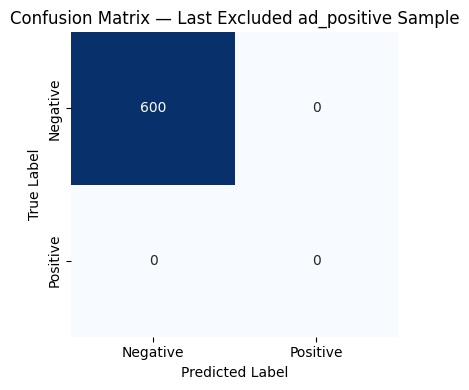

True Negatives : 600
False Positives: 0
False Negatives: 0
True Positives : 0


In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------
# Force both labels (0 = Negative, 1 = Positive)
# -------------------------------------------------
cm = confusion_matrix(
    y_true,
    y_preds,
    labels=[0, 1]
)

# -------------------------------------------------
# Plot confusion matrix
# -------------------------------------------------
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
    cbar=False
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Last Excluded ad_positive Sample")
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Optional: print readable breakdown
# -------------------------------------------------
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives : {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives : {tp}")
